# Classification of Skin Lesion Images as Benign or Malignant


## Introduction: 

The goal of this project was to utilize convolutional neural networks, or CNNs, for the purpose of classifying dermoscopic images as being benign or malignant. The malignancy includes squamous cell carcinoma, basal cell carcinoma, and melanoma, with the majority being melanoma. 

In [1]:
# import libraries

import requests
import json
import random
import os
import glob
import shutil
import itertools

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


## Dataset:

The API for ISIC, or the International Skin Imaging Collaboration, was used to obtain the images that will be used to train, validate, and test the CNNs. The purpose of this public archive of clinical and dermoscopic images serves as a resource for teaching and the development of automated diagnostic systems. Their ultimate goal is to not only reduce the number of melanoma-related deaths through early detection, but to also reduce the number of unnecessary biopsies as well. The URL for this API can be found <a href='https://www.isic-archive.com/#!/topWithHeader/onlyHeaderTop/apiDocumentation'>here</a>.   

#### Use API to Make Dataset:

In [9]:
# function to get the image ids from the ISIC API

def get_image_ids(limit=50, offset=0):
    total_image_ids = []
    
    while True:
        res = requests.get(f'https://isic-archive.com/api/v1/image?limit={limit}&offset={offset}')

        # check to see if the status code of HTTP request is under 400
        if res.ok:
            # so we retrieve a different set of ids in the next request
            offset += limit
            # load json string into a python object (list of dictionaries)
            image_list = json.loads(res.content)
            # extract the id value of the images and create a list of ids for current request
            image_list_ids = [ image['_id'] for image in image_list ]
            # append current list of ids to overall list of ids
            total_image_ids.extend(image_list_ids)

            # check and break if length of received list is less than the limit, which would mean we're at end of list
            if len(image_list) < limit:
                break
        else:
            # if status code is 400 or higher
            print('bad response:', res.status_code)
            break

        # return list of image ids 
    return total_image_ids

In [16]:
# function that uses the image ids from the get_image_ids function to retrieve the actual images

def get_images(image_ids, max_num):
    count = 0
    # looping through the image ids and requesting that specific image from the API to download
    for image_id in image_ids:
        
        # create urls for API (one for download of image and one for metadata of image)
        image_download_url = f'https://isic-archive.com/api/v1/image/{image_id}/download'
        image_metadata = f'https://isic-archive.com/api/v1/image/{image_id}'
        
        # use requests library to make http request from api
        res = requests.get(image_download_url)
        # convert metadata json object to python dictionary
        res_metadata_json = requests.get(image_metadata).json()
        
        # check if benign/malignant and put in corresponding folder
        # stop inserting benign pictures when number of benign pictures 
        # equals number of total malignant pictures from api to have a balanced dataset
        try:
            if res_metadata_json['meta']['clinical']['benign_malignant'] == 'benign' and count < max_num:
                save_path = f"images/BENIGN/{res_metadata_json['name']}.jpeg"
                # check the number of pictures inserted in the BENIGN folder
                count += 1
            elif res_metadata_json['meta']['clinical']['benign_malignant'] == 'malignant':
                save_path = f"images/MALIGNANT/{res_metadata_json['name']}.jpeg"
            
           # save image to corresponding folder     
            with open(save_path, 'wb') as f:
                f.write(res.content)
                # to prevent pictures from being downloaded if not benign or malignant
                save_path = False
        except (KeyError, OSError):
            pass

In [11]:
# gather all image ids with get_image_ids function

image_ids = get_image_ids()

In [12]:
# check how many pictures there are based on the number of ids

len(image_ids)

23906

In [13]:
# shuffle the image_ids to add more randomness to which pictures are downloaded

random.shuffle(image_ids)

In [15]:
# get all pictures downloaded to corresponding folders 

get_images(image_ids, 2285)

In [28]:
# check the number of images in the different classes

print(f"Number of benign images: {len(os.listdir('images/BENIGN'))}")
                                      
print(f"Number of malignant images: {len(os.listdir('images/MALIGNANT'))}")

Number of benign images: 2285
Number of malignant images: 2285


The ISIC archive contained a total of 2285 malignant images. Since that is the class we are most interested in, only 2285 benign images were obtained to keep the classes balanced, for a total of 4570 images.

In [77]:
# Organize data into train, valid, test dirs

def split_sets(test_val_split=0.2):
    
    # change current directory to images
    os.chdir('images')
    
    # check if the train and benign directories exist, if not, create the following directories
    if os.path.isdir('train/BENIGN') is False:
        os.makedirs('train/BENIGN')
        os.makedirs('train/MALIGNANT')
        os.makedirs('test/BENIGN')
        os.makedirs('test/MALIGNANT')
        os.makedirs('valid/BENIGN')
        os.makedirs('valid/MALIGNANT')
        
        # move whatever percent chosen of images to test and validation sets
        for i in glob.glob('BENIGN/ISIC*'):
            shutil.move(i, 'train/BENIGN')      
        for i in glob.glob('MALIGNANT/ISIC*'):
            shutil.move(i, 'train/MALIGNANT')
        for i in random.sample(glob.glob('train/BENIGN/ISIC*'), (round(len(os.listdir('train/BENIGN')) * test_val_split))):
            shutil.move(i, 'test/BENIGN')        
        for i in random.sample(glob.glob('train/MALIGNANT/ISIC*'), (round(len(os.listdir('train/MALIGNANT')) * test_val_split))):
            shutil.move(i, 'test/MALIGNANT')
        for i in random.sample(glob.glob('train/BENIGN/ISIC*'), (round(len(os.listdir('train/BENIGN')) * test_val_split))):
            shutil.move(i, 'valid/BENIGN')      
        for i in random.sample(glob.glob('train/MALIGNANT/ISIC*'), (round(len(os.listdir('train/MALIGNANT')) * test_val_split))):
            shutil.move(i, 'valid/MALIGNANT')
    
    # delete empty directories
    os.rmdir('BENIGN')
    os.rmdir('MALIGNANT')
            
    # change working directory
    os.chdir('../')

In [78]:
# create the train, test, and validation sets with two subsequent 80/20 splits

split_sets()

In [98]:
# confirm that the train, test, and validation sets have the proper number of images

print(f"Number of train benign images: {len(os.listdir('images/train/BENIGN'))}")
                                      
print(f"Number of train malignant images: {len(os.listdir('images/train/MALIGNANT'))}")
      
print(f"Number of test benign images: {len(os.listdir('images/test/BENIGN'))}")
                                      
print(f"Number of test malignant images: {len(os.listdir('images/test/MALIGNANT'))}")

print(f"Number of validation benign images: {len(os.listdir('images/valid/BENIGN'))}")
                                      
print(f"Number of validation malignant images: {len(os.listdir('images/valid/MALIGNANT'))}")

Number of train benign images: 1462
Number of train malignant images: 1462
Number of test benign images: 457
Number of test malignant images: 457
Number of validation benign images: 366
Number of validation malignant images: 365


In [2]:
# set paths for train test valid images

train_path = 'images/train'
valid_path = 'images/valid'
test_path = 'images/test'

In [3]:
# create image data generator for the different sets of images

# include data augmentation techniques for the training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        rotation_range=30,
        horizontal_flip=True,
        vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_no_aug_generator = test_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        classes=['BENIGN','MALIGNANT'])
all_train_no_aug_generator = test_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=2924,
        classes=['BENIGN','MALIGNANT'])
train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
#         batch_size=16,
        classes=['BENIGN','MALIGNANT'])
validation_generator = test_datagen.flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
#         batch_size=16,
        classes=['BENIGN','MALIGNANT'])
test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['BENIGN','MALIGNANT'])

Found 2924 images belonging to 2 classes.
Found 2924 images belonging to 2 classes.
Found 2924 images belonging to 2 classes.
Found 731 images belonging to 2 classes.
Found 914 images belonging to 2 classes.


In [81]:
# use generator to get a batch of training images to inspect

train_imgs, train_labels = next(train_generator)

In [110]:
# inspect shape of the training images batch generated above

train_imgs.shape

(32, 224, 224, 3)

In [93]:
# function to plot some of the images generated above with their corresponding labels

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

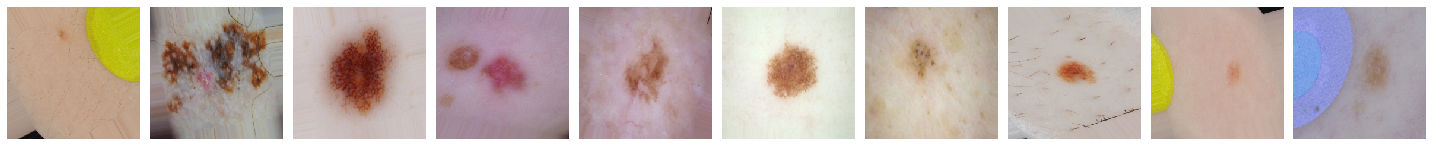

['Benign', 'Malignant', 'Benign', 'Malignant', 'Malignant', 'Benign', 'Malignant', 'Benign', 'Benign', 'Benign', 'Malignant']


In [94]:
# execute plotImages function to view the images with their labels

plotImages(train_imgs)
print(['Benign' if pred[0]==1 else 'Malignant' for pred in train_labels][0:11])

# [1,0] is benign, [0,1] is malignant

In [16]:
# create a function that plots a confusion matrix

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Base CNN Model:
#### With image augmentation

In [113]:
# create a simple convolutional neural network as a base model 

base_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [114]:
# inspect this base model

base_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [115]:
# compile base model with specifying the loss function and metrics

base_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [116]:
# run base model

base_model.fit(x=train_generator, validation_data=validation_generator, epochs=5, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 92 steps, validate for 23 steps
Epoch 1/5
92/92 - 550s - loss: 1.1537 - accuracy: 0.6310 - val_loss: 1.1075 - val_accuracy: 0.5144
Epoch 2/5
92/92 - 532s - loss: 0.6308 - accuracy: 0.7008 - val_loss: 0.5155 - val_accuracy: 0.7291
Epoch 3/5
92/92 - 534s - loss: 0.5451 - accuracy: 0.7415 - val_loss: 0.5065 - val_accuracy: 0.7346
Epoch 4/5
92/92 - 535s - loss: 0.5800 - accuracy: 0.7326 - val_loss: 0.5184 - val_accuracy: 0.7497
Epoch 5/5
92/92 - 538s - loss: 0.5202 - accuracy: 0.7500 - val_loss: 0.4917 - val_accuracy: 0.7510


### Base CNN Model
#### Without image augmentation

In [140]:
# running the base model again without any image augmentation

base_model.fit(x=train_no_aug_generator, validation_data=validation_generator, epochs=5, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 92 steps, validate for 23 steps
Epoch 1/5
92/92 - 504s - loss: 0.5312 - accuracy: 0.7777 - val_loss: 0.4852 - val_accuracy: 0.7278
Epoch 2/5
92/92 - 503s - loss: 0.4616 - accuracy: 0.7798 - val_loss: 0.5102 - val_accuracy: 0.7250
Epoch 3/5
92/92 - 511s - loss: 0.4848 - accuracy: 0.7856 - val_loss: 0.4857 - val_accuracy: 0.7756
Epoch 4/5
92/92 - 478s - loss: 0.4219 - accuracy: 0.8013 - val_loss: 0.5087 - val_accuracy: 0.7415
Epoch 5/5
92/92 - 467s - loss: 0.4021 - accuracy: 0.8143 - val_loss: 0.5350 - val_accuracy: 0.7620


### Base CNN Model:
#### Without image augmentation, smaller batch size, higher epochs

In [152]:
# running the base model again without any image augmentation and with a smaller batch size with higher epochs

base_model.fit(x=train_no_aug_generator, validation_data=validation_generator, epochs=10, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 183 steps, validate for 23 steps
Epoch 1/10
183/183 - 498s - loss: 0.4269 - accuracy: 0.8174 - val_loss: 0.5532 - val_accuracy: 0.7264
Epoch 2/10
183/183 - 494s - loss: 0.3824 - accuracy: 0.8324 - val_loss: 0.5952 - val_accuracy: 0.7592
Epoch 3/10
183/183 - 492s - loss: 0.3389 - accuracy: 0.8399 - val_loss: 0.6534 - val_accuracy: 0.7620
Epoch 4/10
183/183 - 492s - loss: 0.3313 - accuracy: 0.8577 - val_loss: 0.7422 - val_accuracy: 0.7551
Epoch 5/10
183/183 - 492s - loss: 0.3193 - accuracy: 0.8663 - val_loss: 0.6358 - val_accuracy: 0.7346
Epoch 6/10
183/183 - 494s - loss: 0.3444 - accuracy: 0.8779 - val_loss: 0.9166 - val_accuracy: 0.6689
Epoch 7/10
183/183 - 491s - loss: 0.2889 - accuracy: 0.8906 - val_loss: 0.8772 - val_accuracy: 0.6977
Epoch 8/10
183/183 - 490s - loss: 0.2608 - accuracy: 0.9056 - val_loss: 0.7830 - val_accuracy: 0.7387
Epoch 9/10
183/183 - 491s - loss: 0.2332 - accuracy: 0.8977 - val_loss: 1.4307 - val_accura

### Hyperparameter Tuning using GridsearchCV:
#### Ran out of memory

In [118]:
# def create_model(neurons=1, lr=0.1):  # random search passes this hyperparameter() object 
#     model = Sequential()
    
#     model.add(Conv2D(filters=neurons, kernel_size=(3, 3), activation='relu',input_shape=(224, 224, 3)))
#     model.add(MaxPool2D(pool_size=(2,2), strides=2))
#     model.add(Conv2D(filters=neurons, kernel_size=(3,3), activation='relu'))
#     model.add(Flatten())
#     model.add(Dense(units=2, activation='softmax'))

#     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
#                   loss="categorical_crossentropy",
#                   metrics=["accuracy"])
    
#     return model




# # create model
# model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=0)

# # define the grid search parameters
# neurons = [32, 64, 128, 256]
# lr = [0.01, 0.001, 0.0001]

# # create dictionary of parameters
# param_grid = dict(neurons=neurons, lr=lr)

# # create X and y values for gridsearch
# X, y = next(all_train_no_aug_generator)




# # run gridsearchcv and save results 

# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# grid_result = grid.fit(X, y)




# # summarize results of gridsearchcv, tuning the learning rate and number of nodes in the hidden layers

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

## Transfer Learning:

In [4]:
# image preprocessing for vgg16 and vgg19 models

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=10)
train_aug_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, zoom_range=0.4, rotation_range=30) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=10)
train_batches_2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=10)
train_aug_batches_2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input, zoom_range=0.4, rotation_range=30) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=16, shuffle=False)

Found 2924 images belonging to 2 classes.
Found 2924 images belonging to 2 classes.
Found 2924 images belonging to 2 classes.
Found 2924 images belonging to 2 classes.
Found 731 images belonging to 2 classes.
Found 914 images belonging to 2 classes.


### VGG19: 
#### With image augmentation

In [6]:
# create instance of vgg19 model

vgg19_model = tf.keras.applications.vgg19.VGG19()

In [101]:
# view summary of our vgg19 model

vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# create instance of sequential model, then add all the layers from the vgg19 model except the last one to it

vgg19 = Sequential()
for layer in vgg19_model.layers[:-1]:
    vgg19.add(layer)

In [8]:
# make sure that all the layers in our model created above are not trainable

for layer in vgg19.layers:
    layer.trainable = False

In [9]:
# add a last layer to our model with only two units since we have two classes (benign and malignant)

vgg19.add(Dense(units=2, activation='softmax'))

In [105]:
# confirm that this last layer was added successfully 

vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [10]:
# compile the model with the optimizer of sgd, categorical crossentropy for the loss function, and accuracy metrics

vgg19.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [114]:
# fit our vgg19 model to our data

vgg19.fit(x=train_aug_batches_2, validation_data=valid_batches, epochs=4, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 74 steps
Epoch 1/4
293/293 - 1564s - loss: 1.4216 - accuracy: 0.7418 - val_loss: 0.8248 - val_accuracy: 0.7975
Epoch 2/4
293/293 - 1549s - loss: 1.1179 - accuracy: 0.7945 - val_loss: 1.1875 - val_accuracy: 0.7606
Epoch 3/4
293/293 - 1542s - loss: 1.2562 - accuracy: 0.7774 - val_loss: 1.5235 - val_accuracy: 0.7798
Epoch 4/4
293/293 - 1542s - loss: 1.0442 - accuracy: 0.7979 - val_loss: 1.2710 - val_accuracy: 0.7155


### VGG19:
#### No image augmentation

In [11]:
# fit our vgg19 model to our data without image augmentation

vgg19.fit(x=train_batches_2, validation_data=valid_batches, epochs=4, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 74 steps
Epoch 1/4
293/293 - 1768s - loss: 1.5173 - accuracy: 0.7620 - val_loss: 3.1746 - val_accuracy: 0.7100
Epoch 2/4
293/293 - 1610s - loss: 1.2496 - accuracy: 0.8003 - val_loss: 1.3949 - val_accuracy: 0.7962
Epoch 3/4
293/293 - 1571s - loss: 1.0133 - accuracy: 0.8146 - val_loss: 1.3971 - val_accuracy: 0.7456
Epoch 4/4
293/293 - 1541s - loss: 0.9490 - accuracy: 0.8239 - val_loss: 1.0444 - val_accuracy: 0.8167


In [12]:
vgg19.save('vgg19-model1.h5')

In [13]:
# make predictions on test set with vgg19 model

predictions = vgg19.predict(x=test_batches, verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[349 108]
 [ 37 420]]


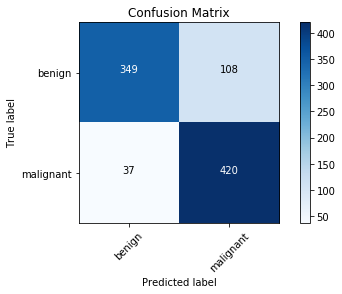

In [17]:
# plot confusion matrix based on predictions to test set

cm_plot_labels = ['benign','malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [18]:
# print classification report based on these predictions from vgg16 model

print(classification_report(test_batches.classes, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.90      0.76      0.83       457
           1       0.80      0.92      0.85       457

    accuracy                           0.84       914
   macro avg       0.85      0.84      0.84       914
weighted avg       0.85      0.84      0.84       914



In [19]:
# fit our vgg19 model to our data without image augmentation and with a great number of epochs

vgg19.fit(x=train_batches_2, validation_data=valid_batches, epochs=10, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 74 steps
Epoch 1/10
293/293 - 1561s - loss: 0.8452 - accuracy: 0.8372 - val_loss: 1.1579 - val_accuracy: 0.7743
Epoch 2/10
293/293 - 1554s - loss: 0.7065 - accuracy: 0.8543 - val_loss: 1.7702 - val_accuracy: 0.7702
Epoch 3/10
293/293 - 1560s - loss: 0.8488 - accuracy: 0.8345 - val_loss: 1.2811 - val_accuracy: 0.8071
Epoch 4/10
293/293 - 1555s - loss: 0.7314 - accuracy: 0.8430 - val_loss: 0.9190 - val_accuracy: 0.7948
Epoch 5/10
293/293 - 1555s - loss: 0.6404 - accuracy: 0.8567 - val_loss: 1.3068 - val_accuracy: 0.8016
Epoch 6/10
293/293 - 1555s - loss: 0.7158 - accuracy: 0.8505 - val_loss: 0.8962 - val_accuracy: 0.8222
Epoch 7/10
293/293 - 1555s - loss: 0.5998 - accuracy: 0.8690 - val_loss: 0.9757 - val_accuracy: 0.8057
Epoch 8/10
293/293 - 1558s - loss: 0.5578 - accuracy: 0.8663 - val_loss: 1.0312 - val_accuracy: 0.8044
Epoch 9/10
293/293 - 1555s - loss: 0.5014 - accuracy: 0.8824 - val_loss: 0.9235 - v

In [20]:
vgg19.save('vgg19-model2.h5')

In [21]:
# make predictions on test set with vgg19 model

predictions = vgg19.predict(x=test_batches, verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[397  60]
 [109 348]]


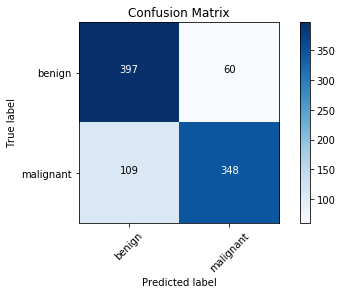

In [22]:
# plot confusion matrix based on predictions to test set

cm_plot_labels = ['benign','malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [23]:
# print classification report based on these predictions from vgg16 model

print(classification_report(test_batches.classes, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       457
           1       0.85      0.76      0.80       457

    accuracy                           0.82       914
   macro avg       0.82      0.82      0.81       914
weighted avg       0.82      0.82      0.81       914



### VGG16: 

#### No image augmentation:

In [4]:
# create instance of vgg16 model

vgg16_model = tf.keras.applications.vgg16.VGG16()

In [5]:
# view summary of our vgg16 model

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# confirm type of vgg16 model

type(vgg16_model)

tensorflow.python.keras.engine.training.Model

In [7]:
# create instance of sequential model, then add all the layers from the vgg16 model except the last one to it

model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [8]:
# make sure that all the layers in our model created above are not trainable

for layer in model.layers:
    layer.trainable = False

In [9]:
# add a last layer to our model with only two units since we have two classes (benign and malignant)

model.add(Dense(units=2, activation='softmax'))

In [10]:
# confirm that this last layer was added successfully 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [11]:
# compile the model with the optimizer of Adam, categorical crossentropy for the loss function, and accuracy metrics

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# fit our vgg16 model to our data

model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 74 steps
Epoch 1/10
293/293 - 1222s - loss: 0.5080 - accuracy: 0.7483 - val_loss: 0.4514 - val_accuracy: 0.7770
Epoch 2/10
293/293 - 1217s - loss: 0.3854 - accuracy: 0.8198 - val_loss: 0.4289 - val_accuracy: 0.7907
Epoch 3/10
293/293 - 1220s - loss: 0.3555 - accuracy: 0.8417 - val_loss: 0.4226 - val_accuracy: 0.7948
Epoch 4/10
293/293 - 1227s - loss: 0.3413 - accuracy: 0.8519 - val_loss: 0.4194 - val_accuracy: 0.8044
Epoch 5/10
293/293 - 1223s - loss: 0.3224 - accuracy: 0.8574 - val_loss: 0.4379 - val_accuracy: 0.8112
Epoch 6/10
293/293 - 1222s - loss: 0.3129 - accuracy: 0.8584 - val_loss: 0.4223 - val_accuracy: 0.8071
Epoch 7/10
293/293 - 1225s - loss: 0.3011 - accuracy: 0.8673 - val_loss: 0.4122 - val_accuracy: 0.8098
Epoch 8/10
293/293 - 1222s - loss: 0.2890 - accuracy: 0.8714 - val_loss: 0.4281 - val_accuracy: 0.8057
Epoch 9/10
293/293 - 1223s - loss: 0.2800 - accuracy: 0.8793 - val_loss: 0.4225 - v

In [14]:
model.save('vgg16-model1.h5')

In [16]:
# make predictions on test set with vgg16 model

predictions = model.predict(x=test_batches, verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[362  95]
 [ 46 411]]


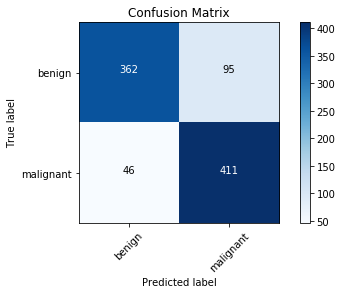

In [17]:
# plot confusion matrix based on predictions to test set

cm_plot_labels = ['benign','malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [18]:
# print classification report based on these predictions from vgg16 model

print(classification_report(test_batches.classes, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       457
           1       0.81      0.90      0.85       457

    accuracy                           0.85       914
   macro avg       0.85      0.85      0.85       914
weighted avg       0.85      0.85      0.85       914



### VGG16: 
#### With image augmentation

In [77]:
# running vgg16 with data augmentation

model.fit(x=train_aug_batches, validation_data=valid_batches, epochs=5, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 74 steps
Epoch 1/5
293/293 - 1252s - loss: 0.3755 - accuracy: 0.8246 - val_loss: 0.4107 - val_accuracy: 0.8057
Epoch 2/5
293/293 - 1297s - loss: 0.3354 - accuracy: 0.8485 - val_loss: 0.4086 - val_accuracy: 0.8098
Epoch 3/5
293/293 - 1298s - loss: 0.3208 - accuracy: 0.8588 - val_loss: 0.4022 - val_accuracy: 0.8071
Epoch 4/5
293/293 - 1505s - loss: 0.3176 - accuracy: 0.8605 - val_loss: 0.4036 - val_accuracy: 0.8112
Epoch 5/5
293/293 - 1616s - loss: 0.3115 - accuracy: 0.8676 - val_loss: 0.3996 - val_accuracy: 0.8085


In [87]:
model.save('vgg16-model2.h5')

In [88]:
# make predictions on test set with vgg16 model

predictions = model.predict(x=test_batches, verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[380  77]
 [ 54 403]]


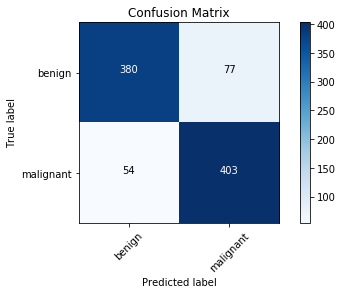

In [89]:
# plot confusion matrix based on predictions to test set

cm_plot_labels = ['benign','malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [90]:
# print classification report based on these predictions from vgg16 model

print(classification_report(test_batches.classes, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       457
           1       0.84      0.88      0.86       457

    accuracy                           0.86       914
   macro avg       0.86      0.86      0.86       914
weighted avg       0.86      0.86      0.86       914



In [95]:
# compile the model with the optimizer of sgd, categorical crossentropy for the loss function, and accuracy metrics

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# running vgg16 with data augmentation

model.fit(x=train_aug_batches, validation_data=valid_batches, epochs=5, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 74 steps
Epoch 1/5
293/293 - 1241s - loss: 0.4217 - accuracy: 0.8140 - val_loss: 0.3940 - val_accuracy: 0.8126
Epoch 2/5
293/293 - 1232s - loss: 0.3315 - accuracy: 0.8492 - val_loss: 0.4219 - val_accuracy: 0.8112
Epoch 3/5
293/293 - 1256s - loss: 0.3159 - accuracy: 0.8550 - val_loss: 0.3916 - val_accuracy: 0.8208
Epoch 4/5
293/293 - 1232s - loss: 0.2933 - accuracy: 0.8745 - val_loss: 0.4187 - val_accuracy: 0.8290
Epoch 5/5
293/293 - 1255s - loss: 0.2905 - accuracy: 0.8666 - val_loss: 0.3972 - val_accuracy: 0.8098


In [96]:
model.save('vgg16-model3.h5')

In [97]:
# make predictions on test set with vgg16 model

predictions = model.predict(x=test_batches, verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[391  66]
 [ 71 386]]


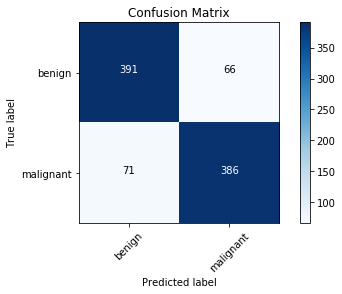

In [98]:
# plot confusion matrix based on predictions to test set

cm_plot_labels = ['benign','malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [99]:
# print classification report based on these predictions from vgg16 model

print(classification_report(test_batches.classes, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       457
           1       0.85      0.84      0.85       457

    accuracy                           0.85       914
   macro avg       0.85      0.85      0.85       914
weighted avg       0.85      0.85      0.85       914



### Inception V3:
#### No image augmentation

In [44]:
# create an Inception V3 model using the imagenet weights, with the input shape of our images, leaving out the last fully connected layer

pre_trained_inceptionv3 = InceptionV3(input_shape = (224,224,3), include_top = False, weights='imagenet')

In [45]:
# make sure that all the layers are frozen/not trainable

for layer in pre_trained_inceptionv3.layers:
    layer.trainable = False

In [46]:
# view summary of the inception v3 model

pre_trained_inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [47]:
# create these layers that will be trainable and then combine them with our frozen inception v3 model

# flatten layer to prepare it for the next dense layer
x = layers.Flatten()(pre_trained_inceptionv3.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# add a layer with two nodes for the two classes
x = layers.Dense(2, activation='softmax')(x)

# combine the newly made trainable layers with the frozen layers
inception_model = tf.keras.Model(pre_trained_inceptionv3.input, x)

# combine our inception model with the following optimizer, loss function, and evaluation metric
inception_model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [48]:
# view the newly combined inception v3 model

inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
______________________________________________________________________________________________

In [51]:
# fit the model with our training set (without any image augmentation)

inception_model.fit(x=train_no_aug_generator, validation_data=validation_generator, epochs=5, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 183 steps, validate for 23 steps
Epoch 1/5
183/183 - 535s - loss: 1.1816 - accuracy: 0.6929 - val_loss: 0.5585 - val_accuracy: 0.7278
Epoch 2/5
183/183 - 526s - loss: 0.6148 - accuracy: 0.7750 - val_loss: 1.4929 - val_accuracy: 0.5677
Epoch 3/5
183/183 - 525s - loss: 0.4710 - accuracy: 0.8311 - val_loss: 0.7774 - val_accuracy: 0.7059
Epoch 4/5
183/183 - 544s - loss: 0.3726 - accuracy: 0.8741 - val_loss: 1.4301 - val_accuracy: 0.6949
Epoch 5/5
183/183 - 587s - loss: 0.3380 - accuracy: 0.9032 - val_loss: 1.0379 - val_accuracy: 0.7278


In [52]:
# save the trained inception v3 model and its weights

inception_model.save('inceptionv3-model1.h5')

 #### Inception V3 with different optimizer


In [54]:
# create another inception v3 model with the same layers and try a different optimizer

inception_model2 = tf.keras.Model(pre_trained_inceptionv3.input, x)

inception_model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
# fit this new model with our training data (again no image augmentation)

inception_model2.fit(x=train_no_aug_generator, validation_data=validation_generator, epochs=5)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 183 steps, validate for 23 steps
Epoch 1/5
183/183 [==============================] - 583s 3s/step - loss: 0.1903 - accuracy: 0.9388 - val_loss: 1.8430 - val_accuracy: 0.6566
Epoch 2/5
183/183 [==============================] - 578s 3s/step - loss: 0.1454 - accuracy: 0.9545 - val_loss: 3.5043 - val_accuracy: 0.5773
Epoch 3/5
183/183 [==============================] - 577s 3s/step - loss: 0.0630 - accuracy: 0.9764 - val_loss: 3.5086 - val_accuracy: 0.6033
Epoch 4/5
183/183 [==============================] - 579s 3s/step - loss: 0.0203 - accuracy: 0.9928 - val_loss: 2.0832 - val_accuracy: 0.6594
Epoch 5/5
183/183 [==============================] - 694s 4s/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 2.4177 - val_accuracy: 0.6621


In [56]:
# save this trained model

inception_model2.save('inceptionv3-model2.h5')

### Inception V3:
#### With image augmentation

In [57]:
# try the second model again but this time with data augmentation for the training set

inception_model2.fit(x=train_generator, validation_data=validation_generator, epochs=5, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 92 steps, validate for 23 steps
Epoch 1/5
92/92 - 619s - loss: 0.6923 - accuracy: 0.7582 - val_loss: 1.1237 - val_accuracy: 0.5773
Epoch 2/5
92/92 - 552s - loss: 0.4602 - accuracy: 0.7856 - val_loss: 0.8158 - val_accuracy: 0.6142
Epoch 3/5
92/92 - 577s - loss: 0.4322 - accuracy: 0.7996 - val_loss: 0.8556 - val_accuracy: 0.5937
Epoch 4/5
92/92 - 608s - loss: 0.4082 - accuracy: 0.8078 - val_loss: 0.6770 - val_accuracy: 0.6539
Epoch 5/5
92/92 - 591s - loss: 0.4119 - accuracy: 0.8027 - val_loss: 0.6173 - val_accuracy: 0.6990


In [58]:
inception_model2.save('inceptionv3-model2-w-aug.h5')

## Methodology:

Image preprocessing techniques largely depended on the model being used. All images were resized to 224 x 224 pixels for the models. Image augmentation techniques were also used to reduce over-fitting since our dataset is not exceptionally large. For transfer learning, special preprocessing techniques were also implemented depending on which pre-trained model was used. 

A basic convolutional neural network was used as the baseline model. In addition, the VGG16, VGG19, and Inception V3 pre-trained models were fine-tuned in an effort to increase accuracy scores. Different optimizers, learning rates, epoch numbers, and batch sizes were used in an effort to hypertune parameters.

Since the benign and malignant classes are balanced, validation accuracy was used as an evaluation metric for training the models. In addition, special attention was given to maximize recall/sensitivity scores since  false negatives are much more detrimental than false positives. 

## Results:

The model that provided the highest recall/sensitivity percentage was the VGG16 model. The last layer, the output layer, was removed and replaced with a dense layer that contains 2 nodes corresponding to the benign and malignant classes. Only this last layer was trained using the training images. All other layers used the original VGG16 pre-trained weights. Preprocessing included subtracting the mean RGB values in order to normalize the data. The adam optimizer was used, with a learning rate of 0.0001. Both the batch size and number of epochs was 10. 

#### Confusion Matrix: 
![](other_images/confusion_matrix.png)

#### Other Scores:
![](other_images/90_recall.png)

As seen above, the model achieved a 90% recall score for the malignant class, along with a 79% recall score for the benign class. An overall accuracy score of 85% was attained. Other models had higher recall scores for the benign class, some as high as 86%, however, their recall scores for the malignant class was lower. 

## Conclusion:

A study performed in 2018 asking 58 international dermatologists to classify 100 dermoscopic images as being benign or a melanoma (the most deadly of all skin cancers). The dermatologists detected 86.6% of melanomas on average, and 71.3% of benign moles. As seen in the results section, our best model achieved a 90% recall for the malignant class (compared to 86.6% in the study) and 79% for the benign class (compared to the 71.3% in the study). This is a promising result and can continue to improve with further hyperparameter tuning. 


## Recommendations:

I recommend that this model is used to assist primary-care physicians and dermatologists, who constitute the front line in melanoma detection, in diagnosing malignant skin cancers. Due to the high recall/sensitivity scores in the malignant class, the probability of a false negative test is quite low. However, the model should not be used as the deciding factor in making a diagnosis. 


## Future Work:

I believe that the model scores can continue to improve with further hyperparameter tuning and the availability of more images. However, larger computing power is required in order to utilize automated systems such as the keras tuner or gridsearch cross-validation to find and optimize hyperparameters. Once higher scores are achieved, the model can be then be deployed via a mobile app to facilitate access and use of this technology. 